In [82]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

In [83]:
data = pd.read_csv('data/EGFR_compounds_lipinski_1.csv', index_col=0)
data.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hbd,n_hba,logp,passed
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,1,3,5.2891,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,1,5,4.9333,True
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,1,5,3.5969,True
4,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,2,4,4.0122,True
5,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,2,5,3.5726,True


In [84]:
data.drop(columns=['molecular_weight', 'n_hbd', 'n_hba', 'logp'], inplace=True)

In [85]:
data.shape

(5874, 6)

In [86]:
PandasTools.AddMoleculeColumnToFrame(data, smilesCol='smiles')

In [87]:
data.shape

(5874, 7)

In [88]:
param_pains = FilterCatalogParams()
param_pains.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
pains = FilterCatalog(param_pains)

In [89]:
matches_pain = []
clean_indices = []
for index, row in data.iterrows():
    molecule = row['ROMol']
    entry = pains.GetFirstMatch(molecule)
    if entry:
        matches_pain.append({
            'chembl_id': row['molecule_chembl_id'],
            'rdkit_molecule': molecule,
            'pains': entry.GetDescription().upper()
        })
    else:
        clean_indices.append(index)

In [90]:
matches_pain = pd.DataFrame(matches_pain)
data = data.loc[clean_indices]

In [91]:
matches_pain.shape, data.shape

((522, 3), (5352, 7))

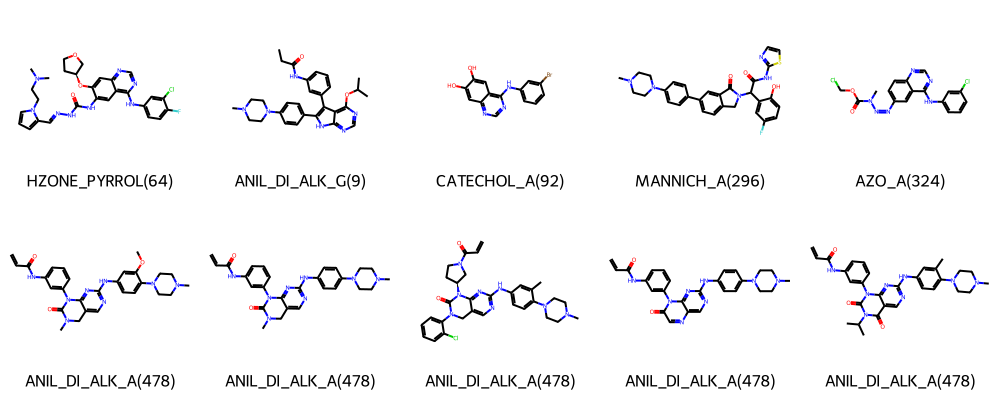

In [92]:
Chem.Draw.MolsToGridImage(
    matches_pain.head(10)['rdkit_molecule'],
    legends=list(matches_pain.head(10)['pains']),
    molsPerRow=5
)

In [93]:
param_brenk = FilterCatalogParams()
param_brenk.AddCatalog(FilterCatalogParams.FilterCatalogs.BRENK)
brenk = FilterCatalog(param_brenk)
brenk

In [94]:
matches_brenk = []
clean_indices = []
for index, row in data.iterrows():
    molecule = row['ROMol']
    provera = False
    matches = brenk.GetMatches(molecule)
    if matches:
        provera = True
        for match in matches:
            matches_brenk.append({
                'chembl_id': row['molecule_chembl_id'],
                'rdkit_molecule': molecule,
                'description': match.GetDescription().upper()
            })
    if not provera:
        clean_indices.append(index)

In [95]:
matches_brenk = pd.DataFrame(matches_brenk)
data = data.loc[clean_indices]

In [96]:
matches_brenk.shape, data.shape

((4216, 3), (2584, 7))

In [97]:
matches_brenk.head()

,chembl_id,rdkit_molecule,description
0,CHEMBL63786,<rdkit.Chem.rdchem.Mol object at 0x000002065BA...,POLYCYCLIC_AROMATIC_HYDROCARBON_2
1,CHEMBL5288888,<rdkit.Chem.rdchem.Mol object at 0x00000206624...,MICHAEL_ACCEPTOR_1
2,CHEMBL1243316,<rdkit.Chem.rdchem.Mol object at 0x00000206624...,ALIPHATIC_LONG_CHAIN
3,CHEMBL1243316,<rdkit.Chem.rdchem.Mol object at 0x00000206624...,MICHAEL_ACCEPTOR_1
4,CHEMBL1243316,<rdkit.Chem.rdchem.Mol object at 0x00000206624...,TRIPLE_BOND


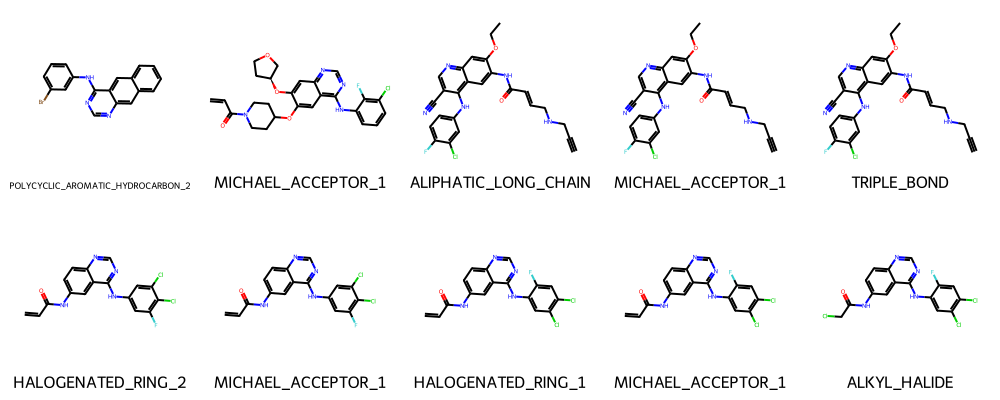

In [100]:
Chem.Draw.MolsToGridImage(
    matches_brenk.head(10)['rdkit_molecule'],
    legends=list(matches_brenk.head(10)['description']),
    molsPerRow=5
)

In [102]:
groups = matches_brenk.groupby(by='description')
groups

In [107]:
group_filter = groups.size()
group_filter

description
2-HALO_PYRIDINE                         26
ACYCLIC_C=C-O                            2
ACYL_HYDRAZINE                           5
ALDEHYDE                                18
ALIPHATIC_LONG_CHAIN                   594
ALKYL_HALIDE                            65
ANILINE                                 81
BETA-KETO/ANHYDRIDE                      7
CATECHOL                                16
CHARGED_OXYGEN_OR_SULFUR_ATOMS          10
CONJUGATED_NITRILE_GROUP                62
CUMARINE                                 2
CYANAMIDE                                1
CYANATE_/AMINONITRILE_/THIOCYANATE      11
DIKETO_GROUP                             3
DISULPHIDE                              21
ENAMINE                                  2
HALOGENATED_RING_1                      36
HALOGENATED_RING_2                      85
HEAVY_METAL                             20
HET-C-HET_NOT_IN_RING                    9
HYDANTOIN                                1
HYDRAZINE                                8

In [117]:
group_filter.sort_values(ascending=False).head(10)

description
MICHAEL_ACCEPTOR_1             1394
ALIPHATIC_LONG_CHAIN            594
OXYGEN-NITROGEN_SINGLE_BOND     520
TRIPLE_BOND                     313
IMINE_1                         205
NITRO_GROUP                     198
HYDROXAMIC_ACID                 136
THIOCARBONYL_GROUP              125
HALOGENATED_RING_2               85
ANILINE                          81
dtype: int64

In [114]:
groups_pains = matches_pain.groupby('pains')

In [115]:
filter_pains = groups_pains.size()
filter_pains

pains
AMINO_ACRIDINE_A(46)       1
ANIL_DI_ALK_A(478)       185
ANIL_DI_ALK_B(251)         5
ANIL_DI_ALK_C(246)         2
ANIL_DI_ALK_G(9)           2
ANIL_NO_ALK(40)            4
ANTHRANIL_ONE_A(38)        1
AZO_A(324)                32
CATECHOL_A(92)            87
CYANO_IMINE_B(17)          2
ENE_CYANO_A(19)           39
ENE_CYANO_E(1)             1
ENE_FIVE_HET_B(90)         5
ENE_FIVE_HET_D(46)         5
ENE_ONE_ENE_A(57)         29
ENE_SIX_HET_D(1)           4
HZONE_ANIL_DI_ALK(35)      1
HZONE_FURAN_A(6)           1
HZONE_PHENOL_A(479)        7
HZONE_PHENOL_B(215)        3
HZONE_PIPZN(79)            2
HZONE_PYRROL(64)           2
IMINE_ONE_A(321)           1
IMINE_ONE_ISATIN(189)      3
INDOL_3YL_ALK(461)        11
MANNICH_A(296)            48
QUINONE_A(370)            38
THIO_UREA_D(8)             1
dtype: int64

In [118]:
filter_pains.sort_values(ascending=False).head(10)

pains
ANIL_DI_ALK_A(478)     185
CATECHOL_A(92)          87
MANNICH_A(296)          48
ENE_CYANO_A(19)         39
QUINONE_A(370)          38
AZO_A(324)              32
ENE_ONE_ENE_A(57)       29
INDOL_3YL_ALK(461)      11
HZONE_PHENOL_A(479)      7
ENE_FIVE_HET_B(90)       5
dtype: int64

In [119]:
data.head(3)

,molecule_chembl_id,IC50,units,smiles,pIC50,passed,ROMol
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,True,<rdkit.Chem.rdchem.Mol object at 0x000002065BA...
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,True,<rdkit.Chem.rdchem.Mol object at 0x00000206624...
4,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,True,<rdkit.Chem.rdchem.Mol object at 0x00000206624...


In [120]:
data.drop(columns=['ROMol'], inplace=True)

In [121]:
data.shape

(2584, 6)

In [122]:
data.to_csv('data/EGFR_clean_3.csv')